<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Chemistry with Variational Quantum Eigensolver**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_5000.png)

### **Variational Quantum Eigensolver to optimize an Ising model with Google Cirq**

Code example: Use the variational quantum eigensolver in Cirq to optimize an Ising model. This demonstrates the four key components of VQE: defining the Hamiltonian (the problem to solve), creating a parameterized quantum circuit (the Ansatz), computing the expectation value of the Hamiltonian, and optimizing the parameters to find the ground state energy.

In [1]:
!pip install cirq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.5 MB/s eta 0:00:00


In [2]:
import cirq
import numpy as np
import scipy.optimize

# 1. Define the Hamiltonian (Ising Model)
def ising_hamiltonian(qubits, J=1.0, h=0.5):
    """Creates an Ising model Hamiltonian."""
    hamiltonian = cirq.PauliSum()
    for i in range(len(qubits)):
        hamiltonian += -J * cirq.Z(qubits[i]) * cirq.Z(qubits[(i + 1) % len(qubits)])  # Periodic boundary
        hamiltonian += -h * cirq.X(qubits[i])  # Using X instead of Z for transverse field
    return hamiltonian

# 2. Define the Ansatz (Parameterized Quantum Circuit)
def ansatz(qubits, params):
    """Creates a simple hardware-efficient ansatz."""
    circuit = cirq.Circuit()

    # First layer of rotations
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[2 * i])(qubit))
        circuit.append(cirq.rz(params[2 * i + 1])(qubit))

    # Entangling layer
    for i in range(len(qubits)):
        circuit.append(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]))

    # Second layer of rotations
    offset = 2 * len(qubits)
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[offset + 2 * i])(qubit))
        circuit.append(cirq.rz(params[offset + 2 * i + 1])(qubit))

    return circuit

# 3. Calculate the Expectation Value
def expectation_value(qubits, params, hamiltonian, simulator):
    """Calculates the expectation value of the Hamiltonian."""
    circuit = ansatz(qubits, params)

    # The key fix: create a proper qubit-to-index mapping
    qubit_map = {qubit: i for i, qubit in enumerate(qubits)}

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector

    return hamiltonian.expectation_from_state_vector(state_vector, qubit_map).real

# 4. Optimization
def vqe_optimization(num_qubits, simulator, max_iterations=100):
    """Performs VQE optimization."""
    qubits = cirq.LineQubit.range(num_qubits)
    hamiltonian = ising_hamiltonian(qubits)

    # 4 parameters per qubit (2 rotation angles per layer × 2 layers)
    initial_params = np.random.uniform(0, 2 * np.pi, 4 * num_qubits)

    def cost_function(params):
        return expectation_value(qubits, params, hamiltonian, simulator)

    result = scipy.optimize.minimize(
        cost_function,
        initial_params,
        method='COBYLA',
        options={'maxiter': max_iterations}
    )

    # Return both the optimized energy and parameters
    return result.fun, result.x

# Example Usage
def main():
    num_qubits = 4
    simulator = cirq.Simulator()

    print(f"Running VQE for {num_qubits} qubits...")
    ground_state_energy, optimal_params = vqe_optimization(num_qubits, simulator)

    print(f"Estimated Ground State Energy: {ground_state_energy}")

    # Optional: Visualize the optimal circuit
    qubits = cirq.LineQubit.range(num_qubits)
    optimal_circuit = ansatz(qubits, optimal_params)
    print("\nOptimal Circuit:")
    print(optimal_circuit)

if __name__ == "__main__":
    main()

Running VQE for 4 qubits...
Estimated Ground State Energy: -4.1708570793271065

Optimal Circuit:
                                                   ┌───────────┐
0: ───Rx(1.05π)───Rz(1.8π)─────@────────────────────@──────────────Rx(1.1π)─────Rz(0.693π)───
                               │                    │
1: ───Rx(1.05π)───Rz(1.46π)────@───@───Rx(1.05π)────┼Rz(0.818π)──────────────────────────────
                                   │                │
2: ───Rx(1.74π)───Rz(0.006π)───────@───@────────────┼Rx(1.67π)─────Rz(1.44π)─────────────────
                                       │            │
3: ───Rx(1.99π)───Rz(-1.94π)───────────@────────────@──────────────Rx(-1.97π)───Rz(0.14π)────
                                                   └───────────┘


### **Quantum Chemistry on H₂ with UCCSD with NVIDIA cuda-q**

###### **Install cudaq**

In [ ]:
!nvidia-smi

Sat May 24 14:17:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   35C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
#!dpkg -i cuda-keyring_1.0-1_all.deb
#!apt-get update
#!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8
#%pip install cuda-quantum

In [ ]:
import numpy as np
print(np.__version__)

1.26.4


This error tells you that you still have NumPy 2.0 or higher installed, but CUDA-Q (or one of its dependencies) is trying to use np.string_ which was removed in NumPy 2.0.
The key line is: AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.

In [ ]:
# Force install NumPy < 2.0
!pip install numpy==1.26.4 --force-reinstall -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


Important: After installing, you **MUST restart your kernel/runtime before running your code again. In Colab: Runtime → Restart runtime**.


In [ ]:
import numpy as np
print(np.__version__)  # Should show 1.26.4

1.26.4


In [ ]:
!pip install openfermionpyscf==0.5 matplotlib==3.8.4 scipy==1.14.0 -q
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.2 MB/s eta 0:00:00


In [ ]:
!pip install cudaq -q
import cudaq
print(cudaq.__version__)
!pip show cudaq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 4.6 MB/s eta 0:00:00
CUDA-Q Version 0.11.0 (https://github.com/NVIDIA/cuda-quantum f5cc3bb1d85abcf1f642f4ddd20ad08bc1d4d200)
Name: cudaq
Version: 0.11.0
Summary: Python bindings for the CUDA-Q toolkit for heterogeneous quantum-classical workflows.
Home-page: https://developer.nvidia.com/cuda-q
Author: NVIDIA Corporation & Affiliates
Author-email: 
License: Apache License Version 2.0

Copyright (c) 2023 - 2025 

In [ ]:
# Select classical GPU fopr simulation or quantum chip for quantum processing
# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

###### **Hydrogen**

**Tutorial**: https://nvidia.github.io/cuda-quantum/0.7.1/examples/python/tutorials/vqe.html

**Video**: [The Quantum Algorithm That Could Make Big Pharma Billions](https://www.youtube.com/watch?v=Fvwyd0536Gc)

**Context**: https://github.com/NVIDIA/cuda-q-academic/tree/main

Let's create H₂ (hydrogen molecule)
* 2 hydrogen atoms in a linear chain
* Distance: 0.7474 Å apart
* Simple diatomic molecule
* Geometry: H--H

In [ ]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
# After running each geometry
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 2
Qubit count: 4
Number of orbitals: 2


* The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

* The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

* Let us first begin by defining the molecule and other metadata about the problem.

In [ ]:
# Generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from CUDA-Q template
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
# CUDA-Q Optimizers for the minimization procedure
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)

-1.1371740035195186


**Integration with Third-Party Optimizers**

* We can also integrate popular libraries like scipy with CUDA-Q.

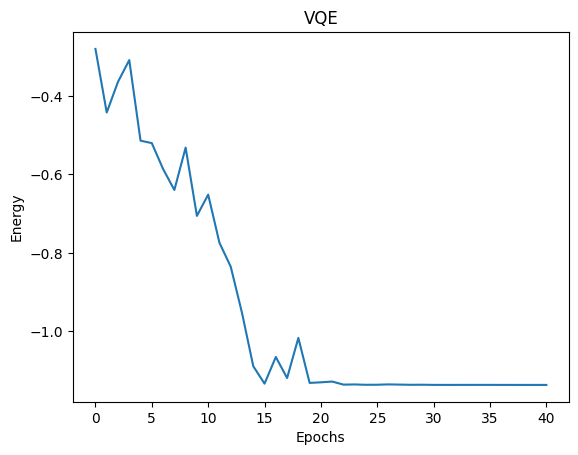

In [ ]:
# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

###### **Ammonia**

Now let's create NH₃ (ammonia)
* 1 nitrogen atom + 3 hydrogen atoms
* Pyramidal structure
* Much more complex molecule
* Geometry: N at center with 3 H atoms around it

The key differences:
* Different atoms: H₂ vs NH₃
* Different complexity: 2 atoms vs 4 atoms
* Different electron count: H₂ has 2 electrons, NH₃ has 10 electrons (N has 7, each H has 1)
* Different qubit requirements: H₂ needs fewer qubits than NH₃

H₂ will need ~4 qubits (2 orbitals × 2 spin states), while NH₃ will need many more qubits due to having more orbitals.

In [ ]:
geometry = [
    ["N", (0.0000, 0.0000, 0.0000)], # Nitrogen
    ["H", (0.0000, 0.0000, 1.0120)], # Hydrogen 1
    ["H", (0.9377, 0.0000, -0.3430)], # Hydrogen 2
    ["H", (-0.9377, 0.0000, -0.3430)] # Hydrogen 3
    ]

hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, "sto-3g", 1, 0)

electron_count = data.n_electrons
qubit_count = 2*data.n_orbitals

In [ ]:
# After running geometry
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 10
Qubit count: 16
Number of orbitals: 8


In [ ]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)

In [ ]:
# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

NameError: name 'parameter_count' is not defined

###### **Appendix Example**

**Example 3** (didnt work so far)

Variational Quantum Eigensolver (VQE) using `CUDA-Q` for algorithm construction and `cuQuantum` for state vector simulation to compute the ground state energy of a simple Hamiltonian $H = Z_0 Z_1 + X_0$. This is a 2-qubit Hamiltonian with Pauli operators.



In [ ]:
#mport cudaq
#import numpy as np
from cudaq import spin

# Define the Hamiltonian H = Z_0 Z_1 + X_0
# The Hamiltonian is defined using CUDA-Q's `spin` operators to represent Pauli matrices
hamiltonian = spin.z(0) * spin.z(1) + spin.x(0)

# Variational ansatz circuit
@cudaq.kernel
def ansatz(theta: float):
    cudaq.h(0)  # Hadamard gate on qubit 0
    cudaq.cx(0, 1)  # CNOT for entanglement
    cudaq.ry(theta, 0)  # Rotation gate with variational parameter

# Objective function for optimization
def vqe_objective(theta):
    return cudaq.observe(ansatz, hamiltonian, theta)

# cuQuantum integration (using cuQuantum's GPU acceleration for state evolution)
#cudaq.set_target('nvidia')  # Select NVIDIA GPU as backend (uses cuQuantum)

# Optimization routine (using scipy)
from scipy.optimize import minimize

# Initial guess
initial_theta = np.random.uniform(0, 2 * np.pi)

# Minimize energy using scipy's optimizer
result = minimize(vqe_objective, initial_theta, method='COBYLA')

print(f"Optimal theta: {result.x}")
print(f"Ground state energy: {result.fun}")

**Hamiltonian Definition:**  
- The Hamiltonian is defined using CUDA-Q's `spin` operators to represent Pauli matrices.

**Quantum Circuit (Ansatz):**  
- The `ansatz` is a simple variational circuit with a Hadamard gate, a CNOT gate for entanglement, and an RY gate parameterized by `theta`.

**Objective Function (VQE Objective):**  
- The energy expectation value of the Hamiltonian is calculated using `cudaq.observe`.

**cuQuantum Integration:**  
- By setting the target to `'nvidia'` via `cudaq.set_target()`, CUDA-Q utilizes `cuQuantum`'s accelerated simulation engine for efficient state vector simulation.

**Optimization Routine:**  
- The `scipy` optimizer minimizes the energy to find the optimal variational parameter.

**Expected Output**
```
Optimal theta: [1.57]      # (Close to π/2 or 3π/2 depending on the optimizer path)
Ground state energy: -1.0  # (Theoretical minimum for this Hamiltonian)
```

**Key Takeaways**
- **CUDA-Q** is used to construct the variational algorithm and manage the hybrid workflow.
- **cuQuantum** accelerates the simulation using NVIDIA GPUs for faster results.
- The combination is ideal for algorithms like VQE, QAOA, or quantum chemistry simulations.